### Diffusion Models

#### References
- [MinDiffusion](https://github.com/cloneofsimo/minDiffusion/tree/master): Minimalistic implementation of diffusion models using Pytorch.
- []()

In [1]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

In [2]:
# Checking GPU acceleration available on M1
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [3]:
torch.set_default_dtype(torch.float32)

### Load the dataset

In [4]:
dataset = load_dataset("jiovine/pixel-art-nouns-2k", split="train")

Found cached dataset parquet (/Users/paulaceccon/.cache/huggingface/datasets/jiovine___parquet/jiovine--pixel-art-nouns-2k-c4f8db66cf6beb74/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


In [5]:
tf = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Resize((32, 32))]
)

# Set the type of the tensor as float32
tf.transforms[0].dtype = torch.float32

In [6]:
dataset = dataset.with_transform(tf)
dataset.set_format(type="torch", columns=["image"])

In [7]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

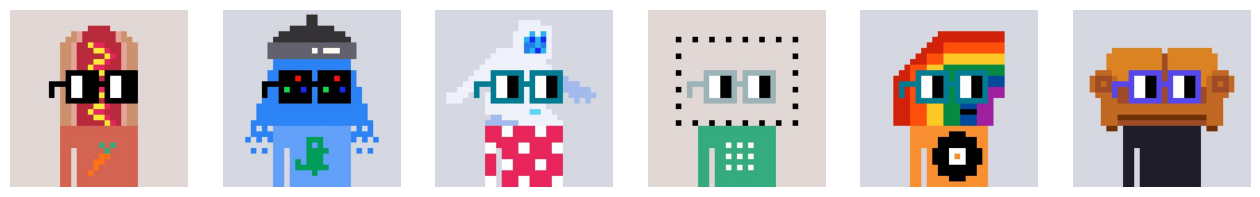

In [8]:
fig, axs = plt.subplots(1, 6, figsize=(16, 4))
for i, image in enumerate(dataset[:6]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()

### Train Model

In [11]:
def train(data_loader: DataLoader, n_epoch: int = 100, device: str = "cuda:0") -> None:
    """
    Train Diffusion Model.

    Parameters
    ----------
    data_loader: data loader.
    n_epoch: number of epochs.
    device: device to run the training on.
    """
    ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
    ddpm.to(device)

    optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        pbar = tqdm(data_loader)
        loss_ema = None
        for x in pbar:
            optim.zero_grad()
            x = x["image"].permute(0, 3, 1, 2)  # [N, C, W, H]
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            torch.save(ddpm.state_dict(), f"./ddpm_weights.pth")

In [12]:
train(data_loader)

Epoch 0 : 


  0%|          | 0/63 [00:16<?, ?it/s]


RuntimeError: "normal_kernel_cpu" not implemented for 'Byte'